In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array

In [2]:
data_dir = Path(r'D:\BingQian.docx\UMS\YEAR 2 SEM 4\MAD\Group Assignment\Data mining\Vege dataset')

train_dir = data_dir/'train'
train_filepaths = list(train_dir.glob(r'**/*.png'))

test_dir = data_dir/'test'
test_filepaths = list(test_dir.glob(r'**/*.png'))

val_dir = data_dir/'val'
val_filepaths = list(test_dir.glob(r'**/*.png'))

In [3]:
def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("\\")[-2] 
              for i in range(len(filepath))]
    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

In [11]:
train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)

In [12]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 1263

Number of different labels: 17

Labels: ['Red Chili Kulai _ Kulai Hybrid' 'Holland Sweet Potato' 'Round Cabbage'
 'Garlic' 'Cucumber' 'Red Onion' 'Green bean _ String bean' 'Green Chili'
 'Yellow Holland Onion' 'Long Eggplant' 'Long Beans' 'Coriander' 'Luffa'
 'Choy Sum' 'Okra' 'Scallions' 'Tomato']


In [13]:
# The DataFrame with the filepaths in one column and the labels in the other one
train_df.head(5)

Filepath  \
0  D:\BingQian.docx\UMS\YEAR 2 SEM 4\MAD\Group As...   
1  D:\BingQian.docx\UMS\YEAR 2 SEM 4\MAD\Group As...   
2  D:\BingQian.docx\UMS\YEAR 2 SEM 4\MAD\Group As...   
3  D:\BingQian.docx\UMS\YEAR 2 SEM 4\MAD\Group As...   
4  D:\BingQian.docx\UMS\YEAR 2 SEM 4\MAD\Group As...   

                            Label  
0  Red Chili Kulai _ Kulai Hybrid  
1            Holland Sweet Potato  
2                   Round Cabbage  
3                          Garlic  
4            Holland Sweet Potato

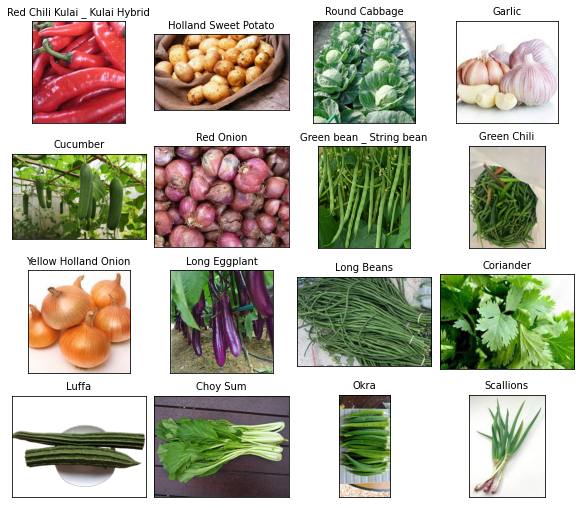

In [14]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 10)
plt.tight_layout(pad=0.5)
plt.show()

In [15]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 1263 validated image filenames belonging to 17 classes.
Found 313 validated image filenames belonging to 17 classes.
Found 313 validated image filenames belonging to 17 classes.


In [16]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [40]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(17, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/5
40/40 [==============================] - 64s 2s/step - loss: 1.3988 - accuracy: 0.6097 - val_loss: 0.7338 - val_accuracy: 0.7476
Epoch 2/5
40/40 [==============================] - 61s 2s/step - loss: 0.3550 - accuracy: 0.8844 - val_loss: 0.4641 - val_accuracy: 0.8562
Epoch 3/5
40/40 [==============================] - 58s 1s/step - loss: 0.1836 - accuracy: 0.9517 - val_loss: 0.4949 - val_accuracy: 0.8466
Epoch 4/5
40/40 [==============================] - 60s 1s/step - loss: 0.0961 - accuracy: 0.9778 - val_loss: 0.4462 - val_accuracy: 0.8754
Epoch 5/5
40/40 [==============================] - 63s 2s/step - loss: 0.0462 - accuracy: 0.9937 - val_loss: 0.3539 - val_accuracy: 0.9105


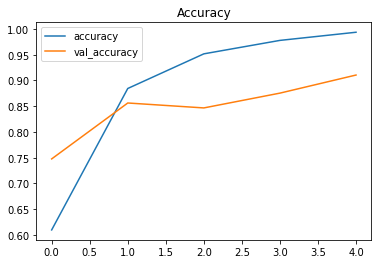

In [41]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

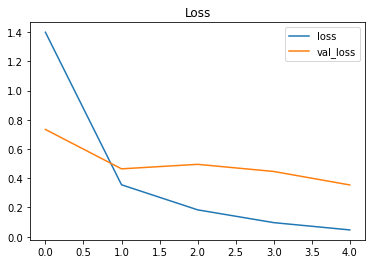

In [42]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [43]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_images.classes]

10/10 [==============================] - 12s 1s/step


In [22]:
print('-- Testing set --\n') 
print(f'Number of pictures: {test_df.shape[0]}\n')

-- Testing set --

Number of pictures: 313



In [55]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 91.05%


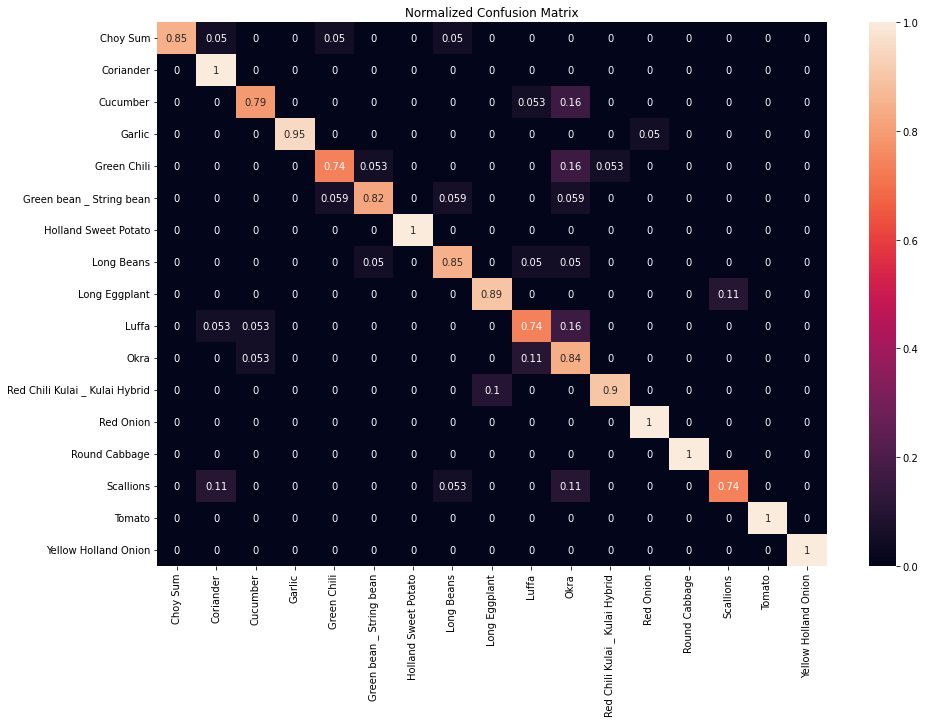

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Normalized Confusion Matrix')
plt.show()

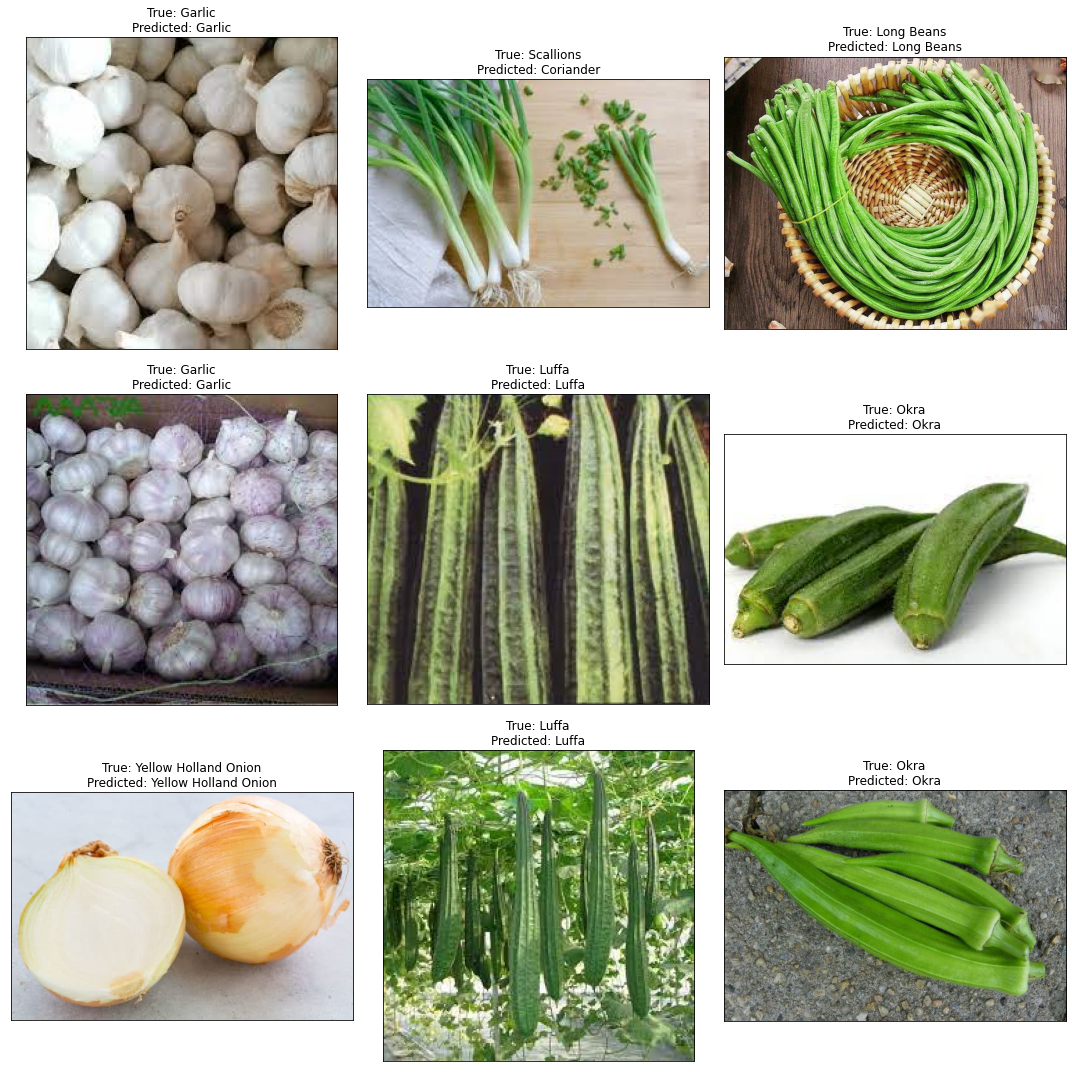

In [23]:
# Display some pictures of the dataset with their labels and the predictions
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

In [24]:
import matplotlib.cm as cm

def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))
    
    return cam_path
    
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "Conv_1"
img_size = (224,224)

# Remove last layer's softmax
model.layers[-1].ativation = None

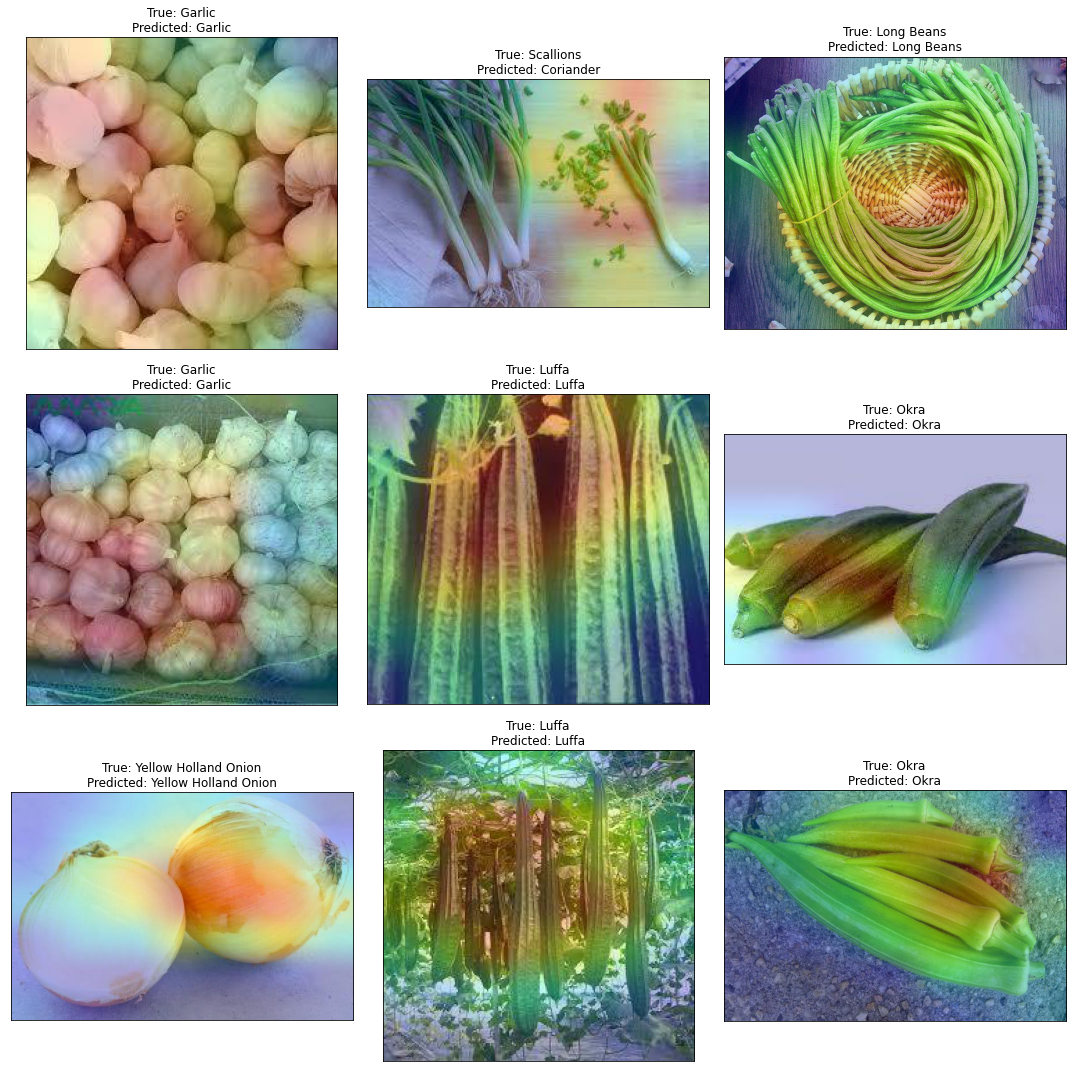

In [25]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[i]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()


In [26]:
labels

{0: 'Choy Sum',
 1: 'Coriander',
 2: 'Cucumber',
 3: 'Garlic',
 4: 'Green Chili',
 5: 'Green bean _ String bean',
 6: 'Holland Sweet Potato',
 7: 'Long Beans',
 8: 'Long Eggplant',
 9: 'Luffa',
 10: 'Okra',
 11: 'Red Chili Kulai _ Kulai Hybrid',
 12: 'Red Onion',
 13: 'Round Cabbage',
 14: 'Scallions',
 15: 'Tomato',
 16: 'Yellow Holland Onion'}

In [27]:
# test predict one image
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

In [28]:
img = output(r"D:\BingQian.docx\UMS\YEAR 2 SEM 4\MAD\Group Assignment\vege\MAD dataset\test\Coriander\image1.png")
img

1/1 [==============================] - 1s 852ms/step


'Coriander'

In [83]:
# save trained model
model.save('vege_model.h5')